# Base model for recommendation system

Outline:
1. Database connection. Data preprocessing. #postgresql

2. Feature extraction from unlabeled text (labels were removed for later accuracy evaluation). #tfidf #pca

3. Model training and evaluating #catboost

4. Model saving and feature uploading to server

tl;dr:
- Catboost TF-IDF+PCA was chosen as the base model (ROC-AUC=0.67)
- Let's try to enhance the result by implementing more sophisticated feature extraction techniques (BERT embeddings clusterization) and additional catboost tuning. See enhanced_model.ipynb

## 1. Connect to DB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


CONN = "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"\
    "postgres.lab.karpov.courses:6432/startml"

In [12]:
# User data

# user_info = pd.read_sql(
#     """SELECT * FROM public.user_data""",
#     con=CONN
# )

user_info = pd.read_csv('data/user_info.csv', index_col=0)
print(user_info.shape)
user_info.sample(5)

(163205, 8)


,user_id,gender,age,country,city,exp_group,os,source
64200,67945,0,21,Russia,Voronezh,0,iOS,ads
156286,161628,1,26,Russia,Taganrog,4,Android,organic
33402,33623,0,19,Russia,Taldom,2,iOS,ads
126345,131675,1,22,Russia,Kirov,1,Android,organic
124957,130286,1,16,Russia,Saint Petersburg,0,iOS,organic


In [3]:
# Posts and topics

# posts_info = pd.read_sql(
#     """SELECT * FROM public.post_text_df""",
#     con=CONN
# )

posts_info = pd.read_csv('data/posts_info.csv', index_col=0)

print(posts_info.shape)
posts_info.sample(5)

(7023, 3)


,post_id,text,topic
277,237,Orange colour clash set for court\n\nA row ove...,business
2545,2955,Living life with waves of socialization hasnt ...,covid
6653,6930,Just as the whole cast and crew knows f*** all...,movie
423,365,Israel looks to US for bank chief\n\nIsrael ha...,business
1202,1020,Conservative MP defects to Labour\n\nA Conserv...,politics


In [4]:
# Feed data
# target column:
#   if post was liked -> 1; else -> 0

# feed_data = pd.read_sql(
#     """SELECT * FROM public.feed_data LIMIT 1000000""",
#     con=CONN
# )

feed_data = pd.read_csv('data/feed_data.csv', index_col=0)

# remove likes
feed_data = feed_data[feed_data.action == 'view']

print(feed_data.shape)
feed_data.sample(5)

(894723, 5)


,timestamp,user_id,post_id,action,target
117417,2021-10-25 15:43:34,156789,4443,view,0
417022,2021-10-02 11:42:53,94212,6109,view,0
235722,2021-10-26 12:11:06,109289,1595,view,0
487642,2021-11-26 21:00:24,109313,5188,view,0
18424,2021-11-29 15:56:32,163295,2506,view,0


## 2. Feature extraction

## 2.1 Text -> TF-IDF

In [5]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [6]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data.shape

c:\Users\grokh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


(7023, 46000)

In [7]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data.sample(10)

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
2422,0.210084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1691,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3522,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3645,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5130,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2151,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4569,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1251,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5061,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Extract features from TF-IDF vector space

### 2.2 Reduce dimensionality of TF-IDF with PCA

In [8]:
from sklearn.decomposition import PCA

def get_PCA(n_components, data):
    centered = data - data.mean()
    pca = PCA(n_components) 
    return pca.fit_transform(centered)

# choose big value of n_components to cover as much variance as possible
pca_decomp = get_PCA(n_components = 100, data=tfidf_data)
pd.DataFrame(pca_decomp).sample(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2874,-0.046837,0.123101,-0.038972,-0.132621,-0.027160,0.082663,0.035443,0.036908,0.100333,0.056636,...,-0.064318,-0.044231,-0.038943,-0.024836,-0.037465,0.023218,-0.028133,-0.029091,0.004113,-0.047117
3422,-0.064799,-0.064660,0.002709,0.012586,0.005694,0.018625,-0.021309,-0.029430,-0.034471,-0.044197,...,0.031162,-0.010572,-0.022586,-0.030279,-0.020635,0.018023,-0.045200,-0.019155,-0.001272,0.005604
5541,0.189469,-0.029100,0.088712,-0.024114,0.007028,-0.020590,0.031403,0.084612,-0.010901,0.034400,...,0.018714,0.016523,-0.027026,-0.018930,-0.015075,0.028202,0.002569,-0.011386,0.003604,0.023769
926,-0.008393,0.074976,-0.005586,-0.001386,0.028093,0.007201,0.035245,0.028369,-0.056413,-0.008590,...,-0.032950,0.010835,0.051120,-0.023259,-0.008108,-0.028817,0.030091,0.025453,0.056718,0.011190
5247,0.021426,-0.015175,-0.017023,-0.013039,0.017727,0.017883,-0.008207,-0.039820,-0.035681,-0.080232,...,-0.002045,0.060593,0.012246,-0.044274,-0.015771,-0.007809,-0.018728,-0.029460,0.009602,0.029662


### Get Features of chosen method

In [9]:
def get_features(df, method):
    methods = {
        # 'kmeans': kmeans.transform,
        'pca' : lambda x: x
    }

    data = methods[method](df) if method!=None else df

    if method=='pca':
        columns = [f"PC_{i}" for i in range(0, data.shape[1])]
    else:
        columns = [f"DistanceTo{i}thCluster" for i in range(0, data.shape[1])]

    return pd.DataFrame(
        data=data,
        columns=columns
    )

dists_df = get_features(pca_decomp, 'pca')
dists_df.sample(5)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
3692,-0.136138,-0.122916,0.020913,0.024850,0.004501,0.003983,0.006806,0.016306,0.017544,-0.006447,...,-0.011333,-0.000004,-0.003948,-0.006409,-0.000115,0.002451,-0.006820,-0.002209,0.002376,-0.002967
2166,-0.148369,-0.135521,0.023437,0.029730,0.006610,0.008170,0.001804,0.029695,0.033404,0.015995,...,0.017316,0.054200,-0.009859,-0.004771,0.018245,0.008705,0.008096,0.007478,0.004697,-0.014032
3734,-0.124053,-0.105359,0.016106,0.018274,-0.000084,-0.007056,0.009366,0.023511,0.004640,0.045566,...,-0.007977,-0.005388,0.021477,-0.010194,-0.006145,-0.004531,0.016317,-0.005545,0.011967,-0.003506
992,-0.040836,0.030669,-0.064991,-0.042275,0.019641,-0.045085,0.092080,-0.023940,-0.006724,-0.026412,...,0.012431,-0.006306,-0.023099,0.009443,0.026887,-0.014167,-0.003852,-0.011877,0.037629,0.030880
2795,-0.064942,0.114295,-0.023399,-0.117909,-0.174319,0.121110,0.032052,0.028790,0.077018,-0.035455,...,0.003653,0.036466,-0.061076,-0.019809,0.063902,0.002436,-0.004860,-0.006405,0.005415,0.017104


### Merge tables

In [10]:
def merge_tables(dists_df, posts_info):
    _posts_info = posts_info.join(dists_df)

    df = pd.merge(
        feed_data, _posts_info,
        on='post_id', 
        how='left'
    )

    df = pd.merge(
        df, user_info,
        on='user_id',
        how='left')

    ### Extract addtional features from timestamp

    df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
    df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

    ### remove unnescessary columns
    df = df.drop([
    #    'timestamp', 
        'action',
        'text',
        'exp_group', # not relevant to task
        'topic' # don't forget to drop topic column - it will be used for clustering performance evaluation in the enhanced_model!
    ], axis=1
    )

    return df.set_index(['user_id', 'post_id']), _posts_info

processed_df, features2server = merge_tables(dists_df, posts_info)
print(processed_df.shape)
processed_df.columns

(894723, 111)


Index(['timestamp', 'target', 'PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5',
       'PC_6', 'PC_7',
       ...
       'PC_99', 'gender', 'age', 'country', 'city', 'exp_group', 'os',
       'source', 'hour', 'month'],
      dtype='object', length=111)

## 3. Model Training

In [11]:
max(processed_df.timestamp), min(processed_df.timestamp)

('2021-12-29 23:43:15', '2021-10-01 06:01:40')

In [12]:
def prepare_data(df):
    ### Split by 2021-12-15

    df_train = df[df.timestamp < '2021-12-15']
    df_test = df[df.timestamp >= '2021-12-15']

    df_train = df_train.drop('timestamp', axis=1)
    df_test = df_test.drop('timestamp', axis=1)

    X_train = df_train.drop('target', axis=1)
    X_test = df_test.drop('target', axis=1)

    y_train = df_train['target']
    y_test = df_test['target']

    return X_train, y_train, X_test, y_test

In [13]:
dists_df = get_features(pca_decomp, 'pca')
processed_df, features2server = merge_tables(dists_df, posts_info)



In [14]:
### Default Catboost 
from catboost import CatBoostClassifier

catboost_tfidf_pca = CatBoostClassifier(task_type='GPU')

object_cols = [
    'gender', 'country',
    'city', 'hour', 'month',
    'os', 'source'
]

X_train, y_train, X_test, y_test = prepare_data(processed_df)

catboost_tfidf_pca.fit(X_train, y_train, object_cols, verbose=False)

In [15]:
from sklearn.metrics import roc_auc_score

print(f"Train ROC-AUC score: {roc_auc_score(y_train, catboost_tfidf_pca.predict_proba(X_train)[:, 1])}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, catboost_tfidf_pca.predict_proba(X_test)[:, 1])}")

Train ROC-AUC score: 0.7125862893568309
Test ROC-AUC score: 0.6708784044909345


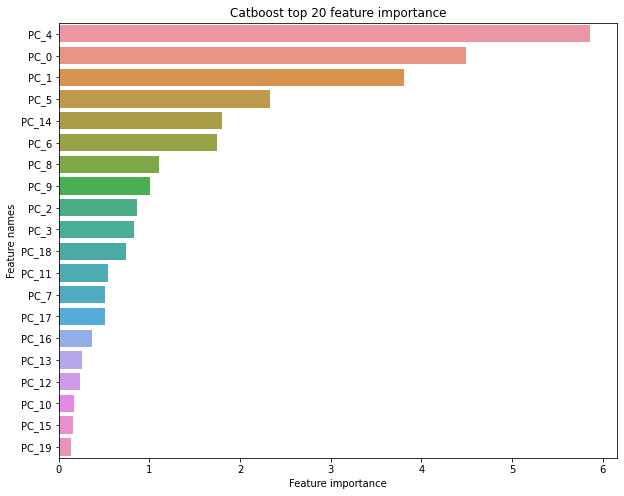

In [16]:

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)[:20]
    feature_names = np.array(names)[:20]
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' top 20 feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')
    
plot_feature_importance(catboost_tfidf_pca.feature_importances_,X_train.columns,'Catboost')

# 4. Saving model and uploading updated features to server

In [30]:
### save model
catboost_tfidf_pca.save_model(
    'airflow/dags/recommendation_models/catboost_base_model',
    format="cbm"                  
)

In [18]:
features2server.to_sql(    
   "grokhi_base_model_posts_info_features",                    
    con=CONN,
    schema="public",                   
    if_exists='replace'            
   )
       

23

In [19]:
test_ = pd.read_sql(
    """SELECT * FROM public.grokhi_base_model_posts_info_features""",
    con=CONN
)

test_

,index,post_id,text,topic,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,...,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,-0.091310,0.158145,-0.004846,-0.104592,-0.136574,-0.227985,...,-0.026653,0.002080,-0.010636,-0.007158,0.015819,-0.014791,0.002329,0.015668,-0.024214,-0.008147
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,-0.086294,0.189302,0.055246,0.034737,-0.049115,-0.034311,...,0.003761,-0.018428,-0.012923,0.031175,-0.033166,-0.008919,-0.029756,0.050651,-0.052845,0.032603
2,2,3,Asian quake hits European shares\n\nShares in ...,business,-0.066972,0.112484,-0.014363,-0.106966,-0.122151,-0.157036,...,0.064911,-0.013983,-0.015171,0.020589,-0.004200,-0.002123,0.005039,0.018215,0.021912,-0.030080
3,3,4,India power shares jump on debut\n\nShares in ...,business,-0.078681,0.093931,-0.001342,-0.066292,-0.102166,-0.084138,...,-0.031490,0.021956,-0.059128,-0.018732,0.006782,-0.046078,0.031146,0.032479,0.024048,0.035566
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,-0.059470,0.051577,-0.005331,-0.035206,-0.035738,-0.012246,...,0.000248,-0.023920,0.000045,0.000553,0.001023,-0.020966,0.032247,0.043402,-0.012083,0.021842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,0.195644,-0.045342,0.141477,-0.041155,0.012690,0.013692,...,0.023634,-0.025578,0.014791,-0.030553,0.026450,-0.020386,-0.008739,0.012307,0.049997,-0.011739
7019,7019,7316,I give this movie 2 stars purely because of it...,movie,0.155323,-0.049286,0.090418,-0.019444,-0.046453,-0.007642,...,0.012560,0.010206,0.032543,-0.001414,-0.006362,0.055020,0.025374,-0.003231,-0.062298,-0.010947
7020,7020,7317,I cant believe this film was allowed to be mad...,movie,0.073017,-0.029164,-0.112411,0.080313,-0.026879,0.014295,...,-0.028316,-0.019773,-0.019424,0.011445,-0.018573,-0.019492,-0.003931,-0.024827,0.015192,-0.021952
7021,7021,7318,The version I saw of this film was the Blockbu...,movie,0.100966,0.012585,-0.087166,0.061139,0.011158,-0.009709,...,0.014815,0.003506,-0.031944,0.025428,-0.027656,0.048391,0.007156,0.007615,-0.042233,0.019055


In [5]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model_path = 'recommendation_models/catboost_base_model'

model.load_model(model_path)

In [58]:
views = pd.read_csv('ab_tests/views.csv')
views['date_s'] = pd.to_datetime(views.timestamp, unit='s')
likes = pd.read_csv('ab_tests/likes.csv')
likes['date_s'] = pd.to_datetime(likes.timestamp, unit='s')

In [59]:
tmp = views.groupby('user_id').exp_group.nunique().reset_index()

duplicate_users = tmp[tmp.exp_group > 1].user_id.values

views = views[~np.in1d(views.user_id, duplicate_users)]
likes = likes[~np.in1d(likes.user_id, duplicate_users)]

In [60]:
posts_features = pd.read_sql(
    """SELECT * FROM public.grokhi_base_model_posts_info_features""",
    con=CONN
)

posts_features = posts_features.drop(
    ['index', 'text', 'topic'], axis=1
)

In [97]:
def get_recommendations(
    user_id:pd.Series, 
    time:pd.Series, 
    user_features:pd.DataFrame, 
    likes:pd.DataFrame, 
    limit:int = 5
) -> list:
    # user_id = views.loc[0,'user_id']

    user_features = user_features[user_features.user_id==user_id].drop('user_id', axis=1)

    add_user_features = dict(zip(user_features.columns, user_features.values[0]))

    user_posts_features = posts_features.assign(**add_user_features)
    user_posts_features = user_posts_features.set_index('post_id')

    user_posts_features['hour'] = time.hour
    user_posts_features['month'] = time.month

    predicts = model.predict_proba(user_posts_features)[:, 1]
    user_posts_features['predicts'] = predicts

    # deleting liked posts
    liked_posts = likes[likes.user_id == user_id].post_id.values

    filtered_ = user_posts_features[~user_posts_features.index.isin(liked_posts)]
    recommended_posts = filtered_.sort_values('predicts')[-limit:].index

    return recommended_posts.to_list()

In [93]:
views_ = views.drop(columns='recommendations').copy()[:1000]

In [98]:
views_['recommendations'] = views_.apply(
    lambda row: get_recommendations(
        row['user_id'], 
        row['date_s'],
        user_features=user_info,
        likes=likes
    ), axis=1
)
views_

,user_id,exp_group,timestamp,date_s,recommendations
0,128381,control,1654030803,2022-05-31 21:00:03,"[2776, 2782, 7122, 5765, 3834]"
1,146885,test,1654030811,2022-05-31 21:00:11,"[1491, 1742, 1830, 7296, 2904]"
2,50948,test,1654030825,2022-05-31 21:00:25,"[1830, 1742, 1253, 7296, 2904]"
3,37703,test,1654030826,2022-05-31 21:00:26,"[1884, 7296, 1742, 1253, 2904]"
4,14661,test,1654030829,2022-05-31 21:00:29,"[1491, 1742, 2904, 1884, 1218]"
...,...,...,...,...,...
995,51158,test,1654037179,2022-05-31 22:46:19,"[3834, 5765, 3677, 4052, 2782]"
996,69954,control,1654037179,2022-05-31 22:46:19,"[249, 1766, 576, 466, 213]"
997,142789,control,1654037191,2022-05-31 22:46:31,"[7296, 576, 1766, 466, 213]"
998,84424,test,1654037196,2022-05-31 22:46:36,"[624, 6966, 5370, 5321, 5950]"
